# Figure 1 Notebook
Originally written by Derek Bogdanoff, edited for portability/clarity by George Hartoularos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import scanpy as sc
import scipy

Some housekeeping:

In [2]:
sc.settings.verbosity=4
sc.settings.set_figure_params(dpi=80)
sc.logging.print_versions()

-----
anndata     0.7.4
scanpy      1.6.0
sinfo       0.3.1
-----
PIL                 7.2.0
anndata             0.7.4
appnope             0.1.0
backcall            0.2.0
cairo               1.19.1
cffi                1.14.2
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
get_version         2.1
h5py                2.10.0
igraph              0.8.2
ipykernel           5.3.4
ipython_genutils    0.2.0
ipywidgets          7.5.1
jedi                0.17.2
joblib              0.16.0
kiwisolver          1.2.0
legacy_api_wrap     1.2
leidenalg           0.8.1
llvmlite            0.33.0+1.g022ab0f
matplotlib          3.3.1
mkl                 2.3.0
mpl_toolkits        NA
natsort             7.0.1
numba               0.50.1
numexpr             2.7.1
numpy               1.19.1
packaging           20.4
pandas              1.1.1
parso               0.7.0
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit    

_GH:_ Adding a prefix here. The idea is that raw data will need to be downloaded separately from a repository (e.g. GEO) and may be in a random location on a person's computer. By having a separate file that all the notebooks read in once, they only have to edit that document with the path to the folder and then, assuming they have not changed the structure of that directory, all the notebooks will work without having to change path names in every single one.

In [3]:
with open('../../path.to.data.txt', 'r') as file:
    prefix = file.readline().strip()

_GH:_ Next 3 cells are commented out because the data on box does not have a directory called `20190319_miSeq`. Instead, it's called `20190319_cell_line_exp` and it's already an h5ad.

In [4]:
# #designate working directory 
# #path should contain: matrix.mtx, plate_map.csv, cell_annotate.txt
# #for scanpy annotations: barcodes.tsv, genes.tsv
# #
# #

# path='/Users/derekbogdanoff/projects/XYZeq/data/20190319_miSeq/human_mouse_gene_count/'

# plate_map='../../../XYZeq/data/20181219_species_exp/plate23_map.csv'

In [5]:
# sc.settings.verbosity=3
# sc.settings.set_figure_params(dpi=80)
# sc.logging.print_versions()
# results_file = './write/results.h5ad'

# #sc.settings = True

# ##load the data
# adata=sc.read(path + 'matrix.mtx', cache=True).T


# ##name the genes
# adata.var_names = [gene.strip() for gene in open(path + 'genes2.tsv', 'r')]


# ##name the cells
# adata.obs_names = [barcode.strip() for barcode in open(path + 'barcodes.tsv', 'r')] 




In [6]:
# adata.var_names_make_unique()

_GH:_ Instead, loading in the h5ad. @Derek should upload the original files to Box if we'd like to convert them here. Otherwise can just provide the h5ad to the community.

## Load Matrix and Filter

In [39]:
adata = sc.read_h5ad(prefix + '293t_3t3_cell_line.h5ad')
#adata = sc.read_h5ad('/Users/derekbogdanoff/projects/XYZeq/cell_line.h5ad')

In [40]:
adata

AnnData object with n_obs × n_vars = 8276 × 121472
    obs: 'barcode'

In [41]:
##post processing filter minimum UMIS and genes
sc.pp.filter_cells(adata, min_counts=200)
sc.pp.filter_cells(adata, min_genes=100)

sc.pp.filter_cells(adata, max_counts=10000)


##post processing filter genes 
  

## define mito genes 
# mito_genes=[name for name in adata.var_names if name.startswith(('mm10_mt-', 'hg19_mt-', 'mt-'))]
mito_genes=[name for name in adata.var_names if (('_mt-' in name) or ('_MT-' in name))]


##create new obs anotation to define percent mito for each cell 
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)*100

##create new obs anotation to define UMIs per cell
adata.obs['n_counts'] = adata.X.sum(axis=1)

filtered out 1365 cells that have less than 200 counts
filtered out 392 cells that have less than 100 genes expressed
filtered out 1 cells that have more than 10000 counts


In [42]:
##filter based on mitochondrial content
adata = adata[adata.obs['percent_mito'] < 1, :]

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [43]:
##plot cells per well
well_counts = adata.obs.groupby('barcode').size()

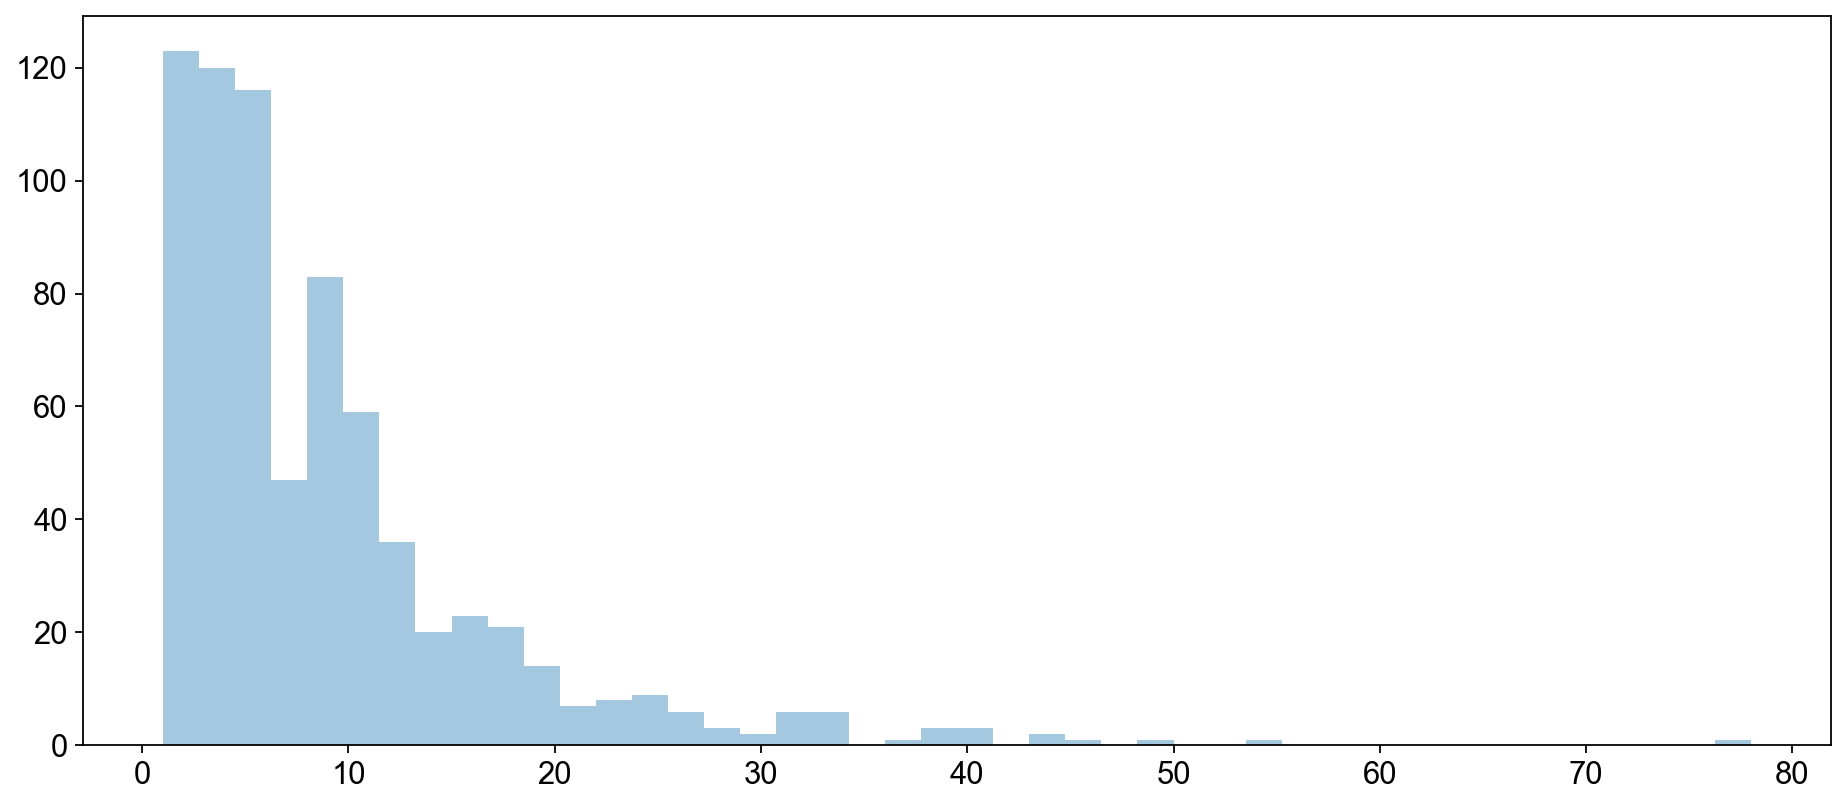

In [44]:
plt.rcParams['figure.figsize'] = [14, 6]

sns.distplot(well_counts,
             kde=False
            )

plt.grid(False)

In [45]:
adata

View of AnnData object with n_obs × n_vars = 6447 × 121472
    obs: 'barcode', 'n_counts', 'n_genes', 'percent_mito'

## Make Barnyard

In [46]:
mouse_genes=[name for name in adata.var_names if name.startswith('mm10_')]
human_genes=[name for name in adata.var_names if name.startswith('hg19_')]

In [47]:
adata.obs['mouse_counts'] = np.sum(adata[:, mouse_genes].X, axis=1)
adata.obs['human_counts'] = np.sum(adata[:, human_genes].X, axis=1)

Trying to set attribute `.obs` of view, copying.


In [48]:
cmap = mpl.colors.ListedColormap(['royalblue','lightgrey', 'orangered'])

In [49]:
np.seterr(divide = 'ignore') 
adata.obs['ratio'] = np.log10(np.true_divide(adata.obs['mouse_counts'], adata.obs['human_counts']))

def cell_call(counts):
    if counts['ratio'] > 0.66:
        return 'M'
    elif counts['ratio'] < -0.66:
        return 'H'
    else:
        return 'C'

adata.obs['cell_call']=adata.obs.apply(lambda counts: cell_call(counts), axis=1)

### Figure 1D:

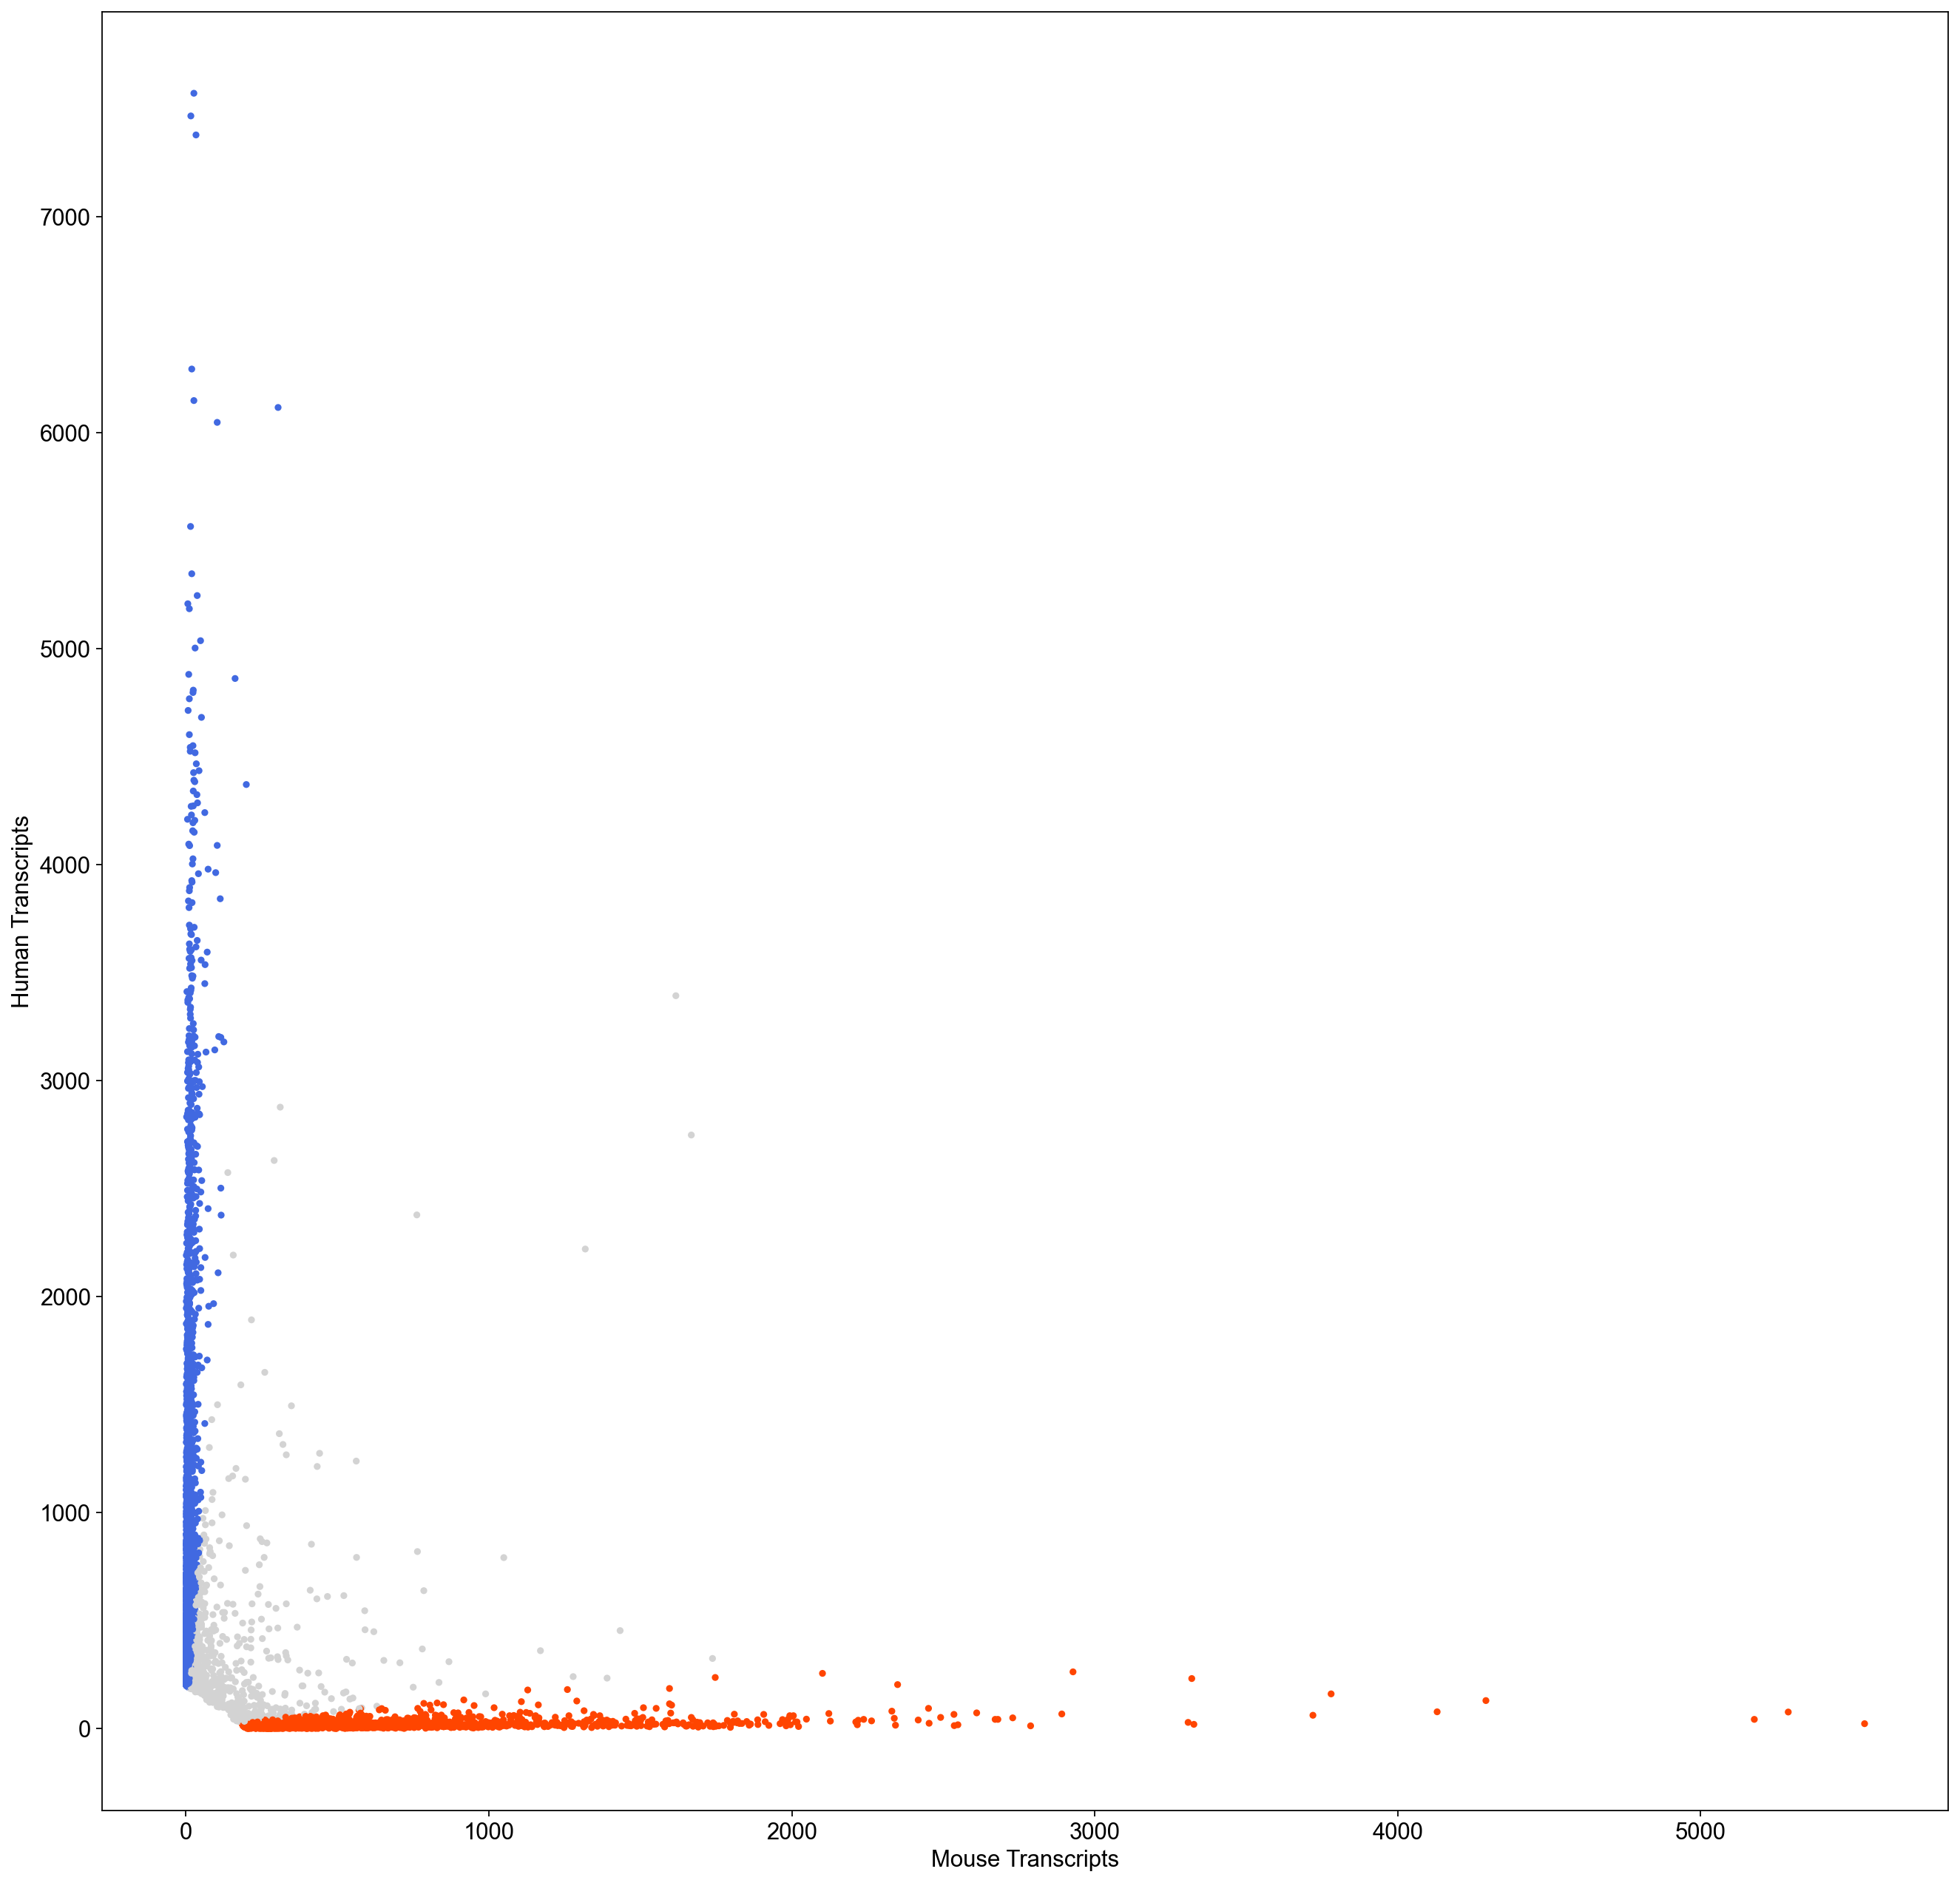

In [50]:
plt.figure(figsize=(20, 20))

plt.scatter(x=adata.obs['mouse_counts'], 
            y=adata.obs['human_counts'],
            s=10,
            c=adata.obs['ratio'],
           cmap=cmap)

plt.xlabel('Mouse Transcripts')
plt.ylabel('Human Transcripts')
plt.grid(b=False)

In [51]:
adata.obs['cell_call'].value_counts()

H    4389
M    1728
C     330
Name: cell_call, dtype: int64

In [52]:
adata.obs['cell_call'].value_counts(normalize=True)

H    0.680782
M    0.268032
C    0.051187
Name: cell_call, dtype: float64

In [53]:
#multiply mixed species by 2 to account for doublets of same species
adata.obs['cell_call'].value_counts(normalize=True)['C']*2

0.10237319683573755

## Violin Plots

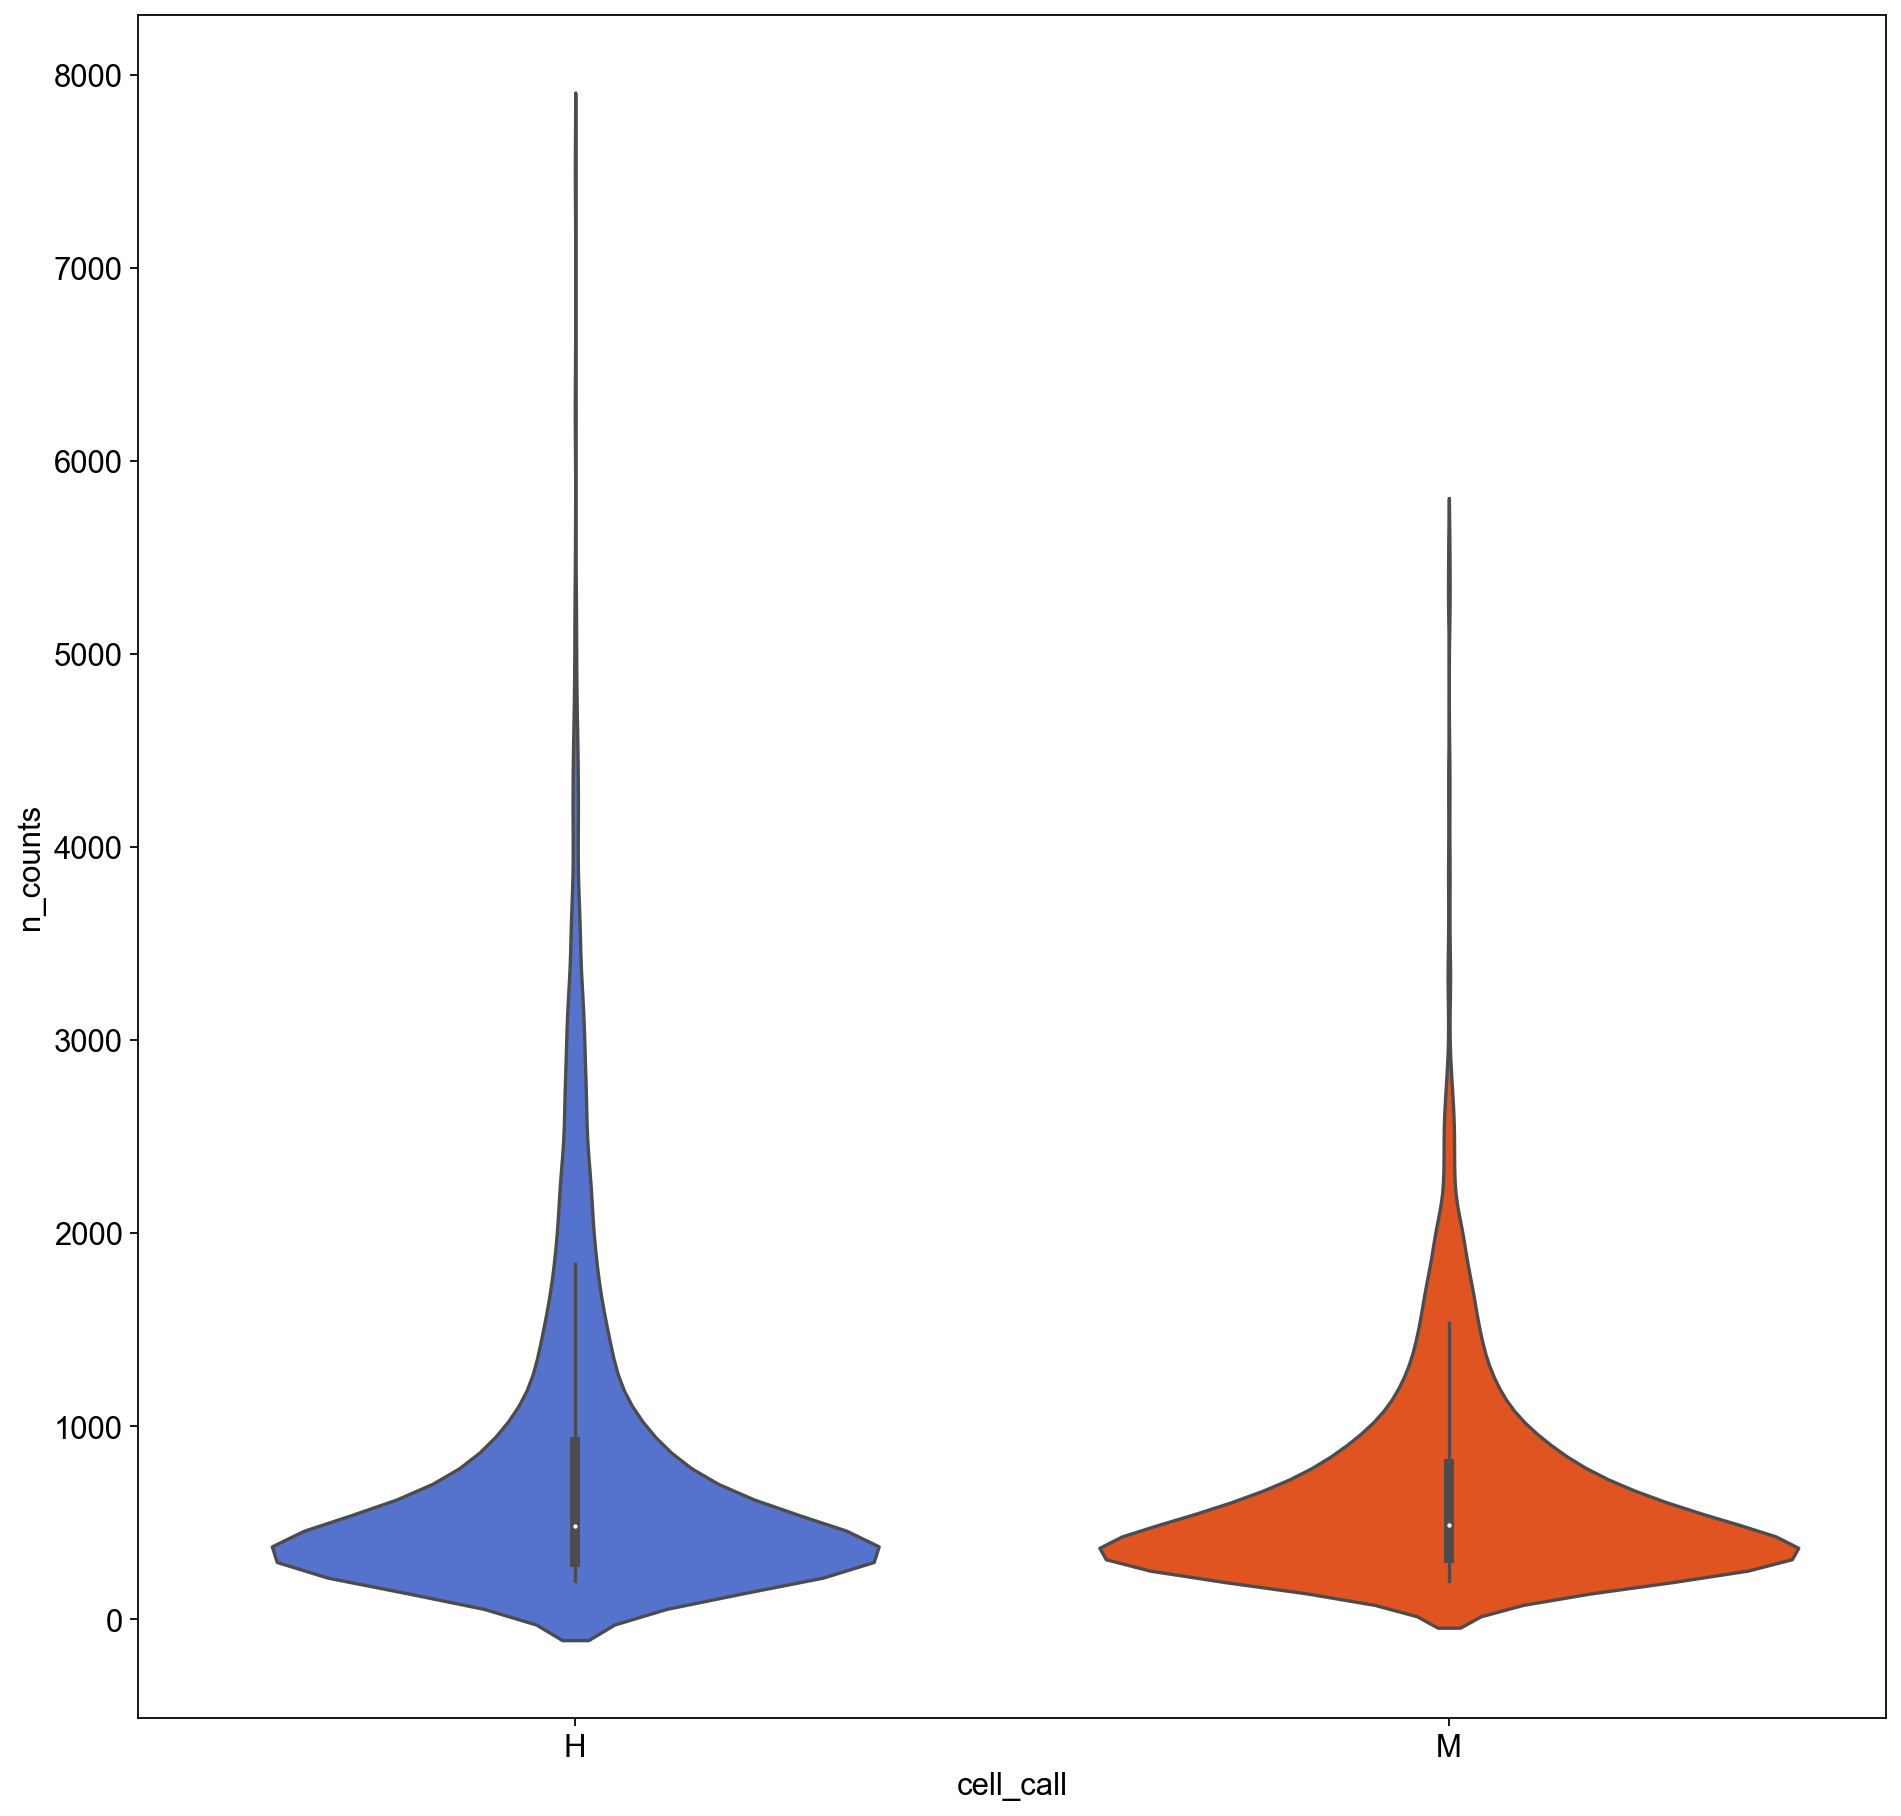

In [54]:
plt.rcParams['figure.figsize'] = [14, 14]

sns.violinplot(data=adata[adata.obs['cell_call'] != 'C'].obs,
               x='cell_call',
               y='n_counts',
               palette=['royalblue', 'orangered']
              );

#plt.axis('off')
plt.grid(False)

In [55]:
print("median UMIs mouse: " + str(np.median(adata[adata.obs['cell_call']=='M'].obs.n_counts)))

print("median UMIs human: " + str(np.median(adata[adata.obs['cell_call']=='H'].obs.n_counts)))



median UMIs mouse: 490.5
median UMIs human: 483.0


/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


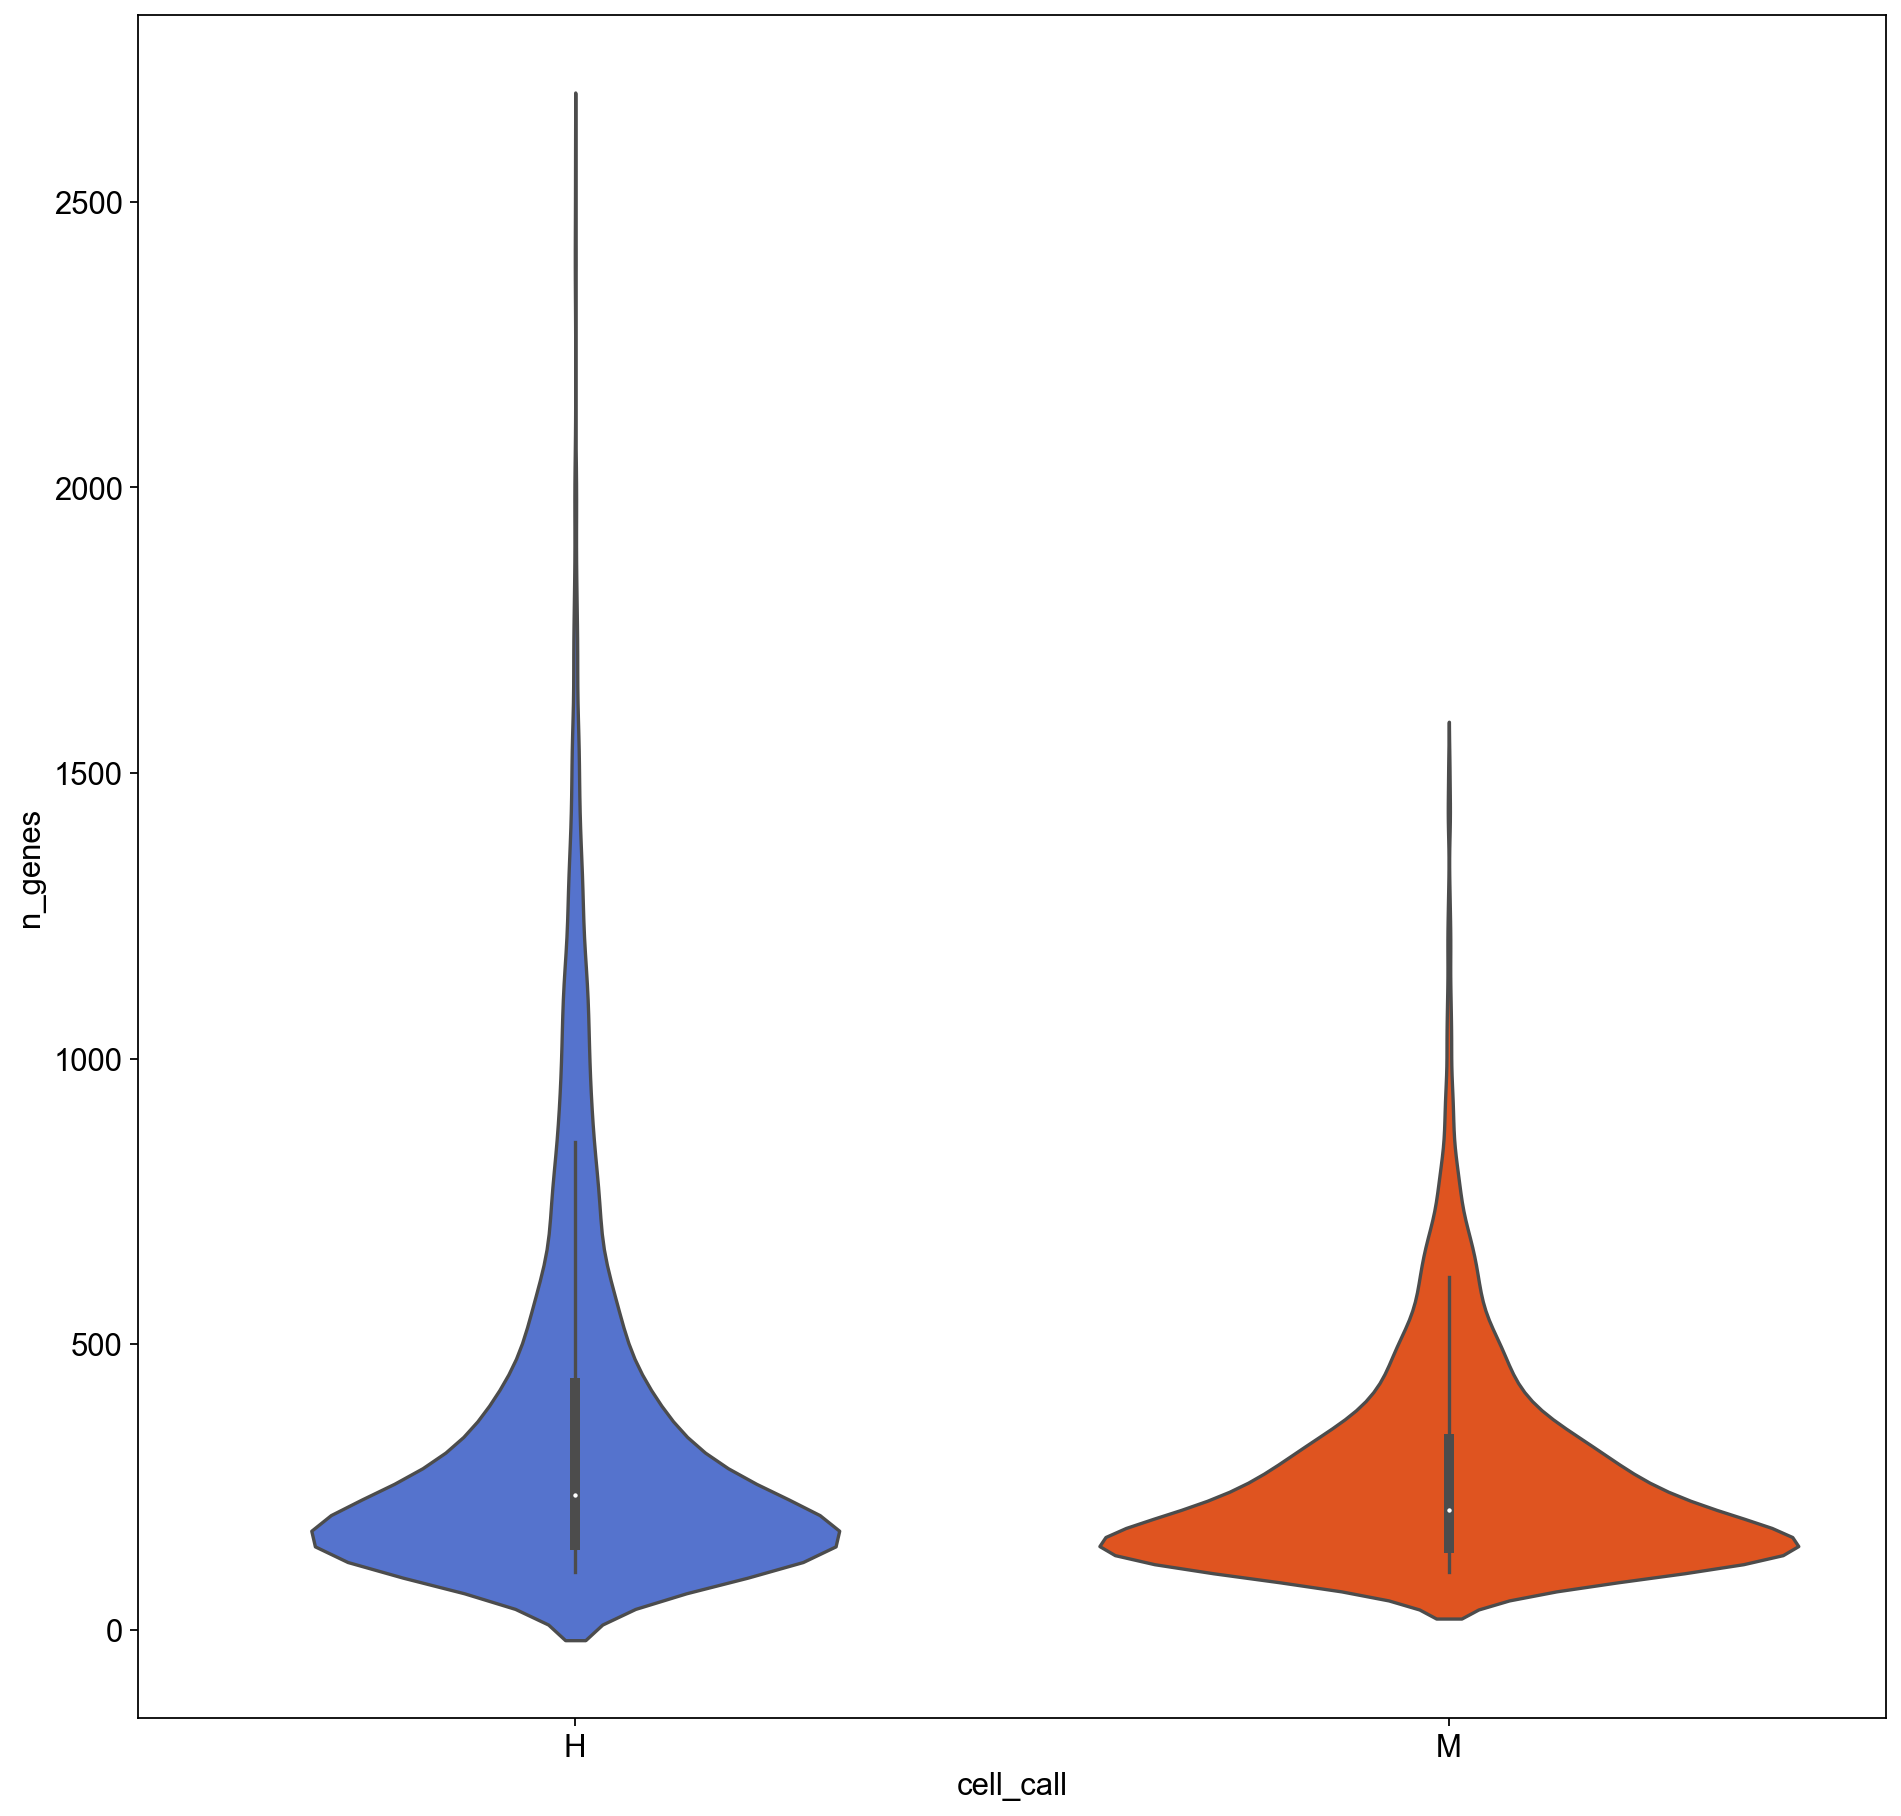

In [56]:
plt.rcParams['figure.figsize'] = [14, 14]

sns.violinplot(data=adata[adata.obs['cell_call'] != 'C'].obs,
               x='cell_call',
               y='n_genes',
               palette=['royalblue', 'orangered']
              )

#plt.axis('off')
plt.grid(False) 

In [57]:
print("median genes mouse: " + str(np.median(adata[adata.obs['cell_call']=='M'].obs.n_genes)))

print("median genes human: " + str(np.median(adata[adata.obs['cell_call']=='H'].obs.n_genes)))



median genes mouse: 210.0
median genes human: 236.0


/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


# Generate Cluster Info

In [58]:
adata

AnnData object with n_obs × n_vars = 6447 × 121472
    obs: 'barcode', 'n_counts', 'n_genes', 'percent_mito', 'mouse_counts', 'human_counts', 'ratio', 'cell_call'

In [59]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    Gene indices [119932] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [60]:
adata.raw = adata

In [61]:
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use


/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'cell_call' as categorical


    finished (0:01:14)
    ... clipping at max_value 10


In [79]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=15)

computing PCA
    on highly variable genes
    with n_comps=50


/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    finished (0:00:16)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
        initialized `.distances` `.connectivities` 
    computing neighbors
    using 'X_pca' with n_pcs = 15
    computed neighbors (0:00:00)
    computed connectivities (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.

In [98]:
sc.tl.tsne(adata,
           n_pcs=15
          )

computing tSNE
    using 'X_pca' with n_pcs = 15
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6447 samples in 0.007s...
[t-SNE] Computed neighbors for 6447 samples in 0.857s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6447
[t-SNE] Computed conditional probabilities for sample 2000 / 6447
[t-SNE] Computed conditional probabilities for sample 3000 / 6447
[t-SNE] Computed conditional probabilities for sample 4000 / 6447
[t-SNE] Computed conditional probabilities for sample 5000 / 6447
[t-SNE] Computed conditional probabilities for sample 6000 / 6447
[t-SNE] Computed conditional probabilities for sample 6447 / 6447
[t-SNE] Mean sigma: 0.677420
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.487869
[t-SNE] KL divergence after 1000 iterations: 1.949561
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:36)


In [128]:
sc.tl.leiden(adata,
            resolution=0.1)

running Leiden clustering
    finished: found 2 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


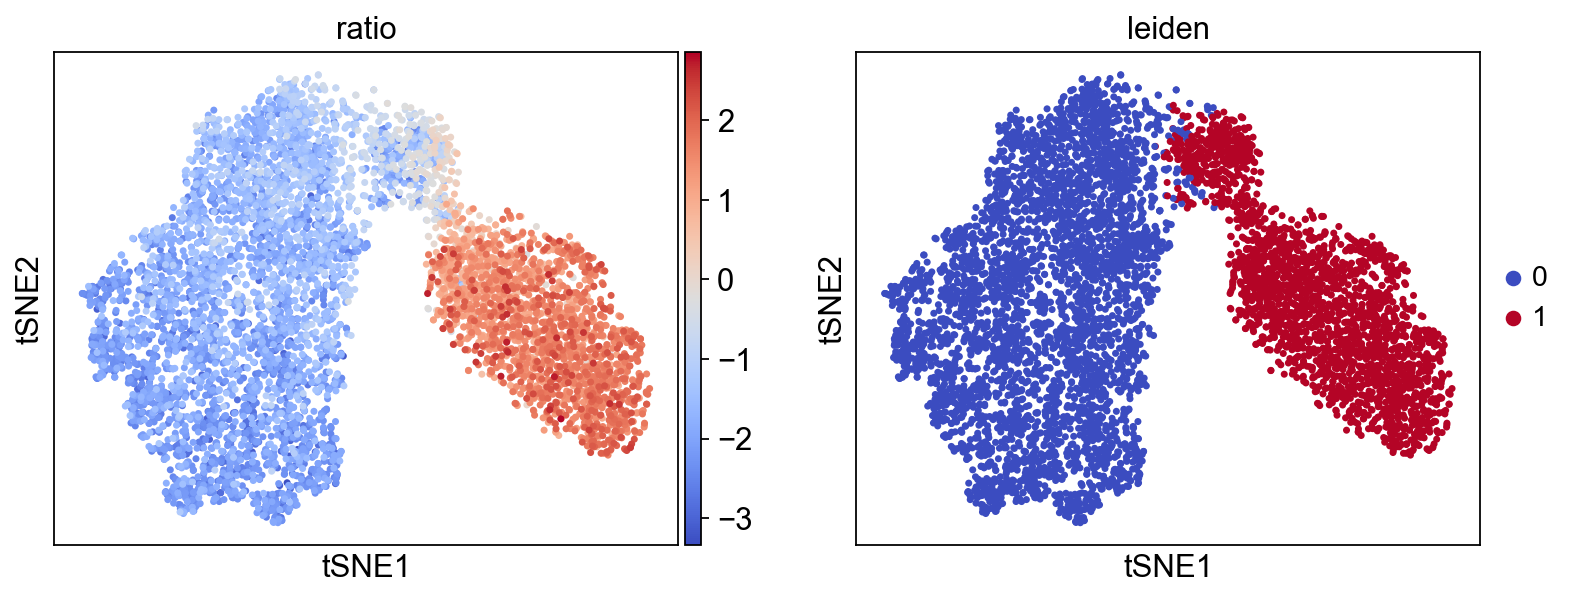

In [129]:
plt.rcParams['figure.figsize'] = [5, 4]

sc.pl.tsne(adata,
          color=['ratio','leiden'],
           color_map='coolwarm',
           palette='coolwarm',
          s=40)

In [120]:
### define new annotation for celltype based on leiden clusters ####

cell_type_df=pd.DataFrame(adata.obs['leiden'])
    
def label (row):
   if row['leiden'] == '0':
      return 'Hek293t'
   if row['leiden'] =='1':
      return '3T3'
    
cell_type_df_ =  pd.DataFrame(cell_type_df.apply (lambda row: label(row), axis=1),)

cell_type_df_.columns=['CellType']

adata.obs['CellType']=cell_type_df_

In [122]:
##write processed data as h5ad
adata.write_h5ad('293t_3t3_cell_line_processed.h5ad')

/Users/derekbogdanoff/miniconda3/envs/xyzeq/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'CellType' as categorical


## Column Graphs Across Array

In [31]:
##read barcode map and attach coordinates to adata

#plate_map = prefix + 'plate23_map.csv'
plate_map = "/Users/derekbogdanoff/projects/XYZeq/plate23_map.csv"

spatial_map=pd.read_csv(plate_map,
                        header=None,
                        names=['barcode', 'X', 'Y']
                       )

adata.obs = adata.obs.reset_index().merge(spatial_map, on='barcode',how='left').set_index('index')




In [32]:
df = adata.obs.groupby('X')['cell_call'].value_counts(['']).unstack()
df.columns.name='Cell Species'
df=df[['M','H','C']]

In [33]:
barplot_cmap=mpl.colors.ListedColormap(['orangered','royalblue','lightgrey'])

### Figure 1E:

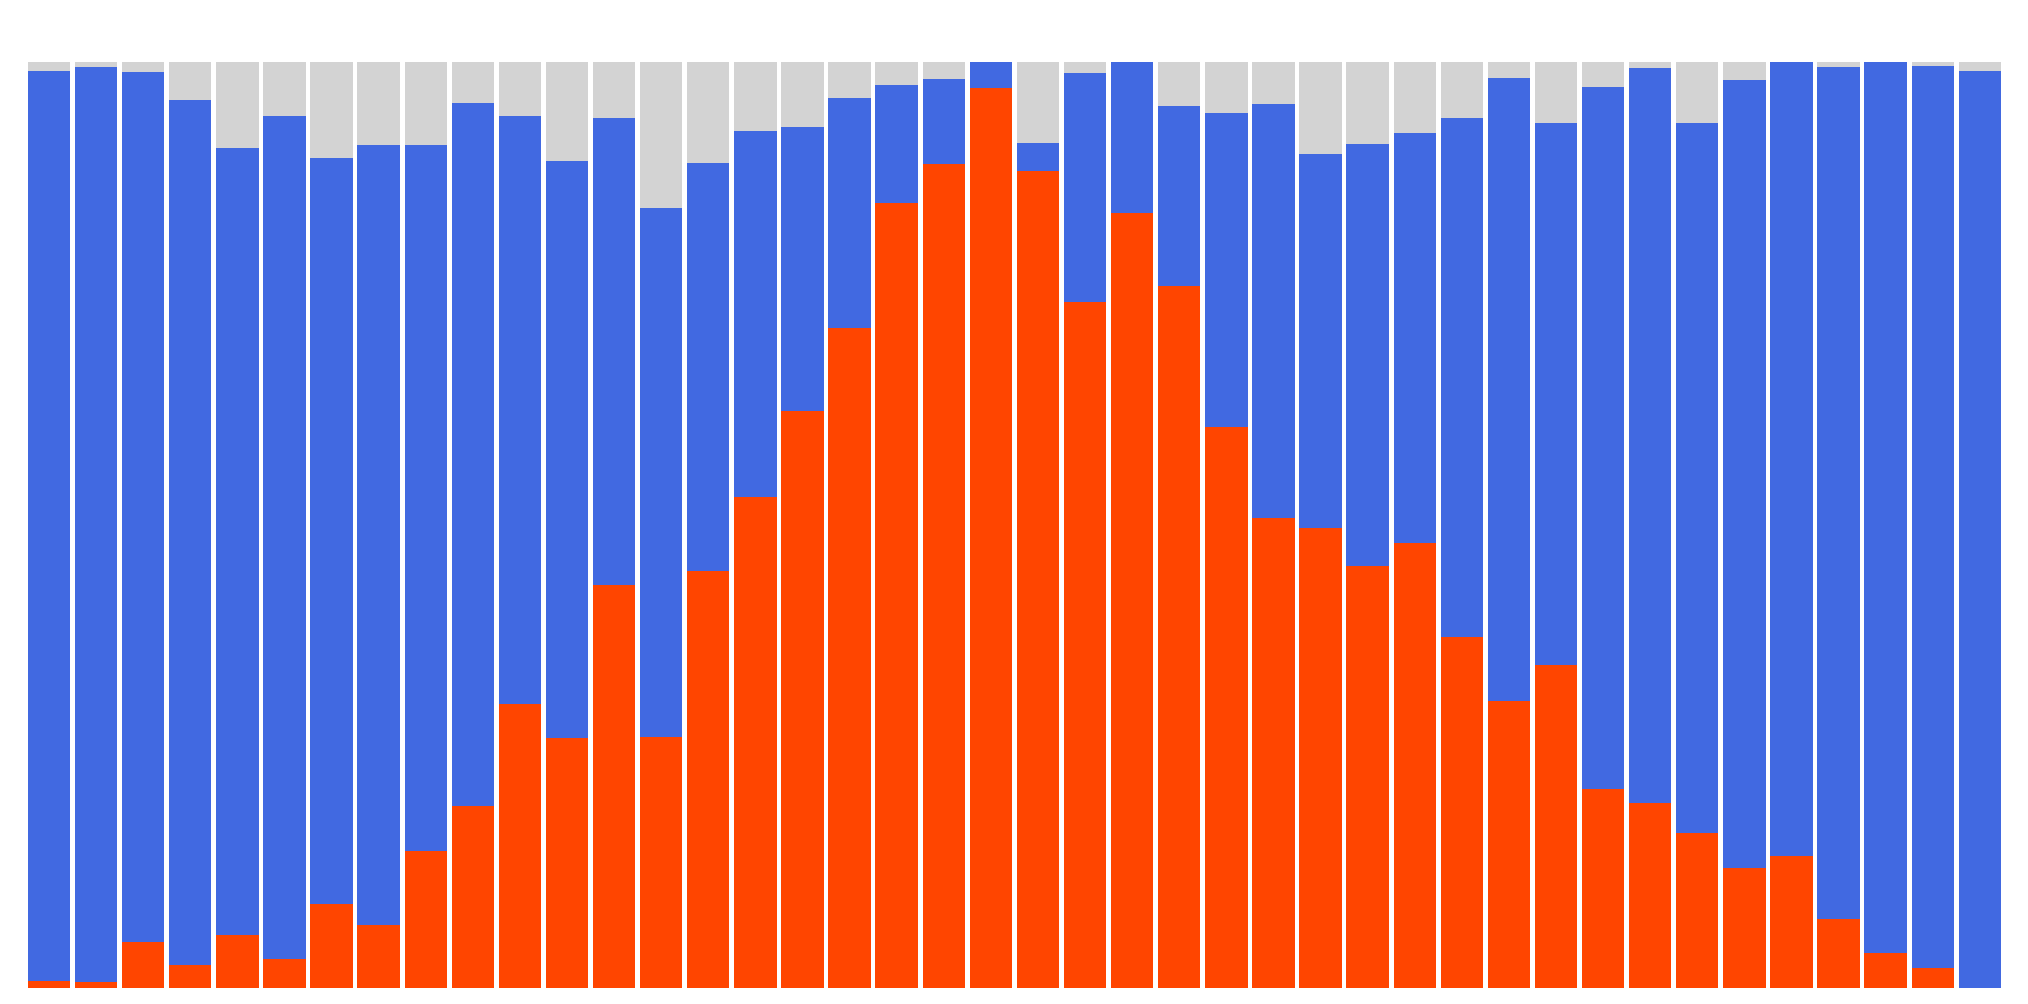

In [34]:
plt.rcParams['figure.figsize'] = [16, 8]


df.plot.bar(stacked=True,
                width=0.9, 
                cmap=barplot_cmap, 
                ecolor='white',
              # alpha=.6,
                legend=None
               )


plt.axis('off')
plt.grid(False)              

## Calculate Lin's Concordance Correlation Coefficient

To see the concordance between the proportion of cells (Human vs Mouse) we sought to place in each column of the array and what we observed in the data.

In [35]:
def ss (l): # one liner from https://stackoverflow.com/questions/26894227/sum-of-squares-in-a-list-in-one-line
    return np.array(sum(map(lambda x:x*x,l)))

# Next several functions from https://github.com/philrose/python/blob/master/stats.py
# Adjusted for python3 and consistency of variables
def lcov (x,y, keepdims=0):
    """
Returns the estimated covariance of the values in the passed
array (i.e., N-1).  Dimension can equal None (ravel array first), an
integer (the dimension over which to operate), or a sequence (operate
over multiple dimensions).  Set keepdims=1 to return an array with the
same number of dimensions as inarray.
Usage:   lcov(x,y,keepdims=0)
"""

    n = len(x)
    xmn = np.mean(x)
    ymn = np.mean(y)
    xdeviations = [0]*len(x)
    ydeviations = [0]*len(y)
    for i in range(len(x)):
        xdeviations[i] = x[i] - xmn
        ydeviations[i] = y[i] - ymn
    ss = 0.0
    for i in range(len(xdeviations)):
        ss = ss + xdeviations[i]*ydeviations[i]
    return ss/float(n-1)


def lvar (inlist):
    """
Returns the variance of the values in the passed list using N-1
for the denominator (i.e., for estimating population variance).
Usage:   lvar(inlist)
"""
    n = len(inlist)
    mn = np.mean(inlist)
    deviations = [0]*len(inlist)
    for i in range(len(inlist)):
        deviations[i] = inlist[i] - mn
    return ss(deviations)/float(n-1)


def amean (inarray,dimension=None,keepdims=0):
    """
Calculates the arithmatic mean of the values in the passed array.
That is:  1/n * (x1 + x2 + ... + xn).  Defaults to ALL values in the
passed array.  Use dimension=None to flatten array first.  REMEMBER: if
dimension=0, it collapses over dimension 0 ('rows' in a 2D array) only, and
if dimension is a sequence, it collapses over all specified dimensions.  If
keepdims is set to 1, the resulting array will have as many dimensions as
inarray, with only 1 'level' per dim that was collapsed over.
Usage:   amean(inarray,dimension=None,keepdims=0)
Returns: arithematic mean calculated over dim(s) in dimension
"""
    if inarray.dtype in [np.int_, np.short,np.ubyte]:
        inarray = inarray.astype(np.float_)
    if dimension == None:
        inarray = np.ravel(inarray)
        mysum = np.add.reduce(inarray)
        denom = float(len(inarray))
    elif type(dimension) in [IntType,FloatType]:
        mysum = amysum(inarray,dimension)
        denom = float(inarray.shape[dimension])
        if keepdims == 1:
            shp = list(inarray.shape)
            shp[dimension] = 1
            mysum = np.reshape(mysum,shp)
    else: # must be a TUPLE of dims to average over
        dims = list(dimension)
        dims.sort()
        dims.reverse()
        mysum = inarray *1.0
        for dim in dims:
            mysum = np.add.reduce(mysum,dim)
        denom = np.array(np.multiply.reduce(np.take(inarray.shape,dims)),np.float_)
        if keepdims == 1:
            shp = list(inarray.shape)
            for dim in dims:
                shp[dim] = 1
            mysum = np.reshape(mysum,shp)
    return mysum/denom

def llincc(x,y):
    """
Calculates Lin's concordance correlation coefficient.
Usage:   alincc(x,y)    where x, y are equal-length arrays
Returns: Lin's CC
"""
    covar = lcov(x,y)*(len(x)-1)/float(len(x))  # correct denom to n
    xvar = lvar(x)*(len(x)-1)/float(len(x))  # correct denom to n
    yvar = lvar(y)*(len(y)-1)/float(len(y))  # correct denom to n
    lincc = (2 * covar) / ((xvar+yvar) +((amean(x)-amean(y))**2))
    return lincc

In [36]:
col_props = pd.read_csv(prefix + 'cell.line.column.proportions.csv', index_col=0)
col_props.columns = ['M', 'H']
col_props['C'] = 0
col_props = col_props.divide(col_props.sum(1),axis='rows')

FileNotFoundError: [Errno 2] No such file or directory: '/path/to/box.data/cell.line.column.proportions.csv'

In [37]:
col_props.fillna(0, inplace=True)
df.fillna(0, inplace=True)

NameError: name 'col_props' is not defined

In [38]:
col_props['H/(H+M)'] = col_props['H']/col_props[['H', 'M']].sum(1)

NameError: name 'col_props' is not defined

In [60]:
df['H/(H+M)'] = df['H']/df[['H', 'M']].sum(1)

In [61]:
print(llincc(col_props['H'].values, df['H'].values))
print(llincc(col_props['M'].values, df['M'].values))
print(llincc(col_props['H/(H+M)'].values, df['H/(H+M)'].values))

0.9507090322571932
0.8834071455320606
0.9129458879937271


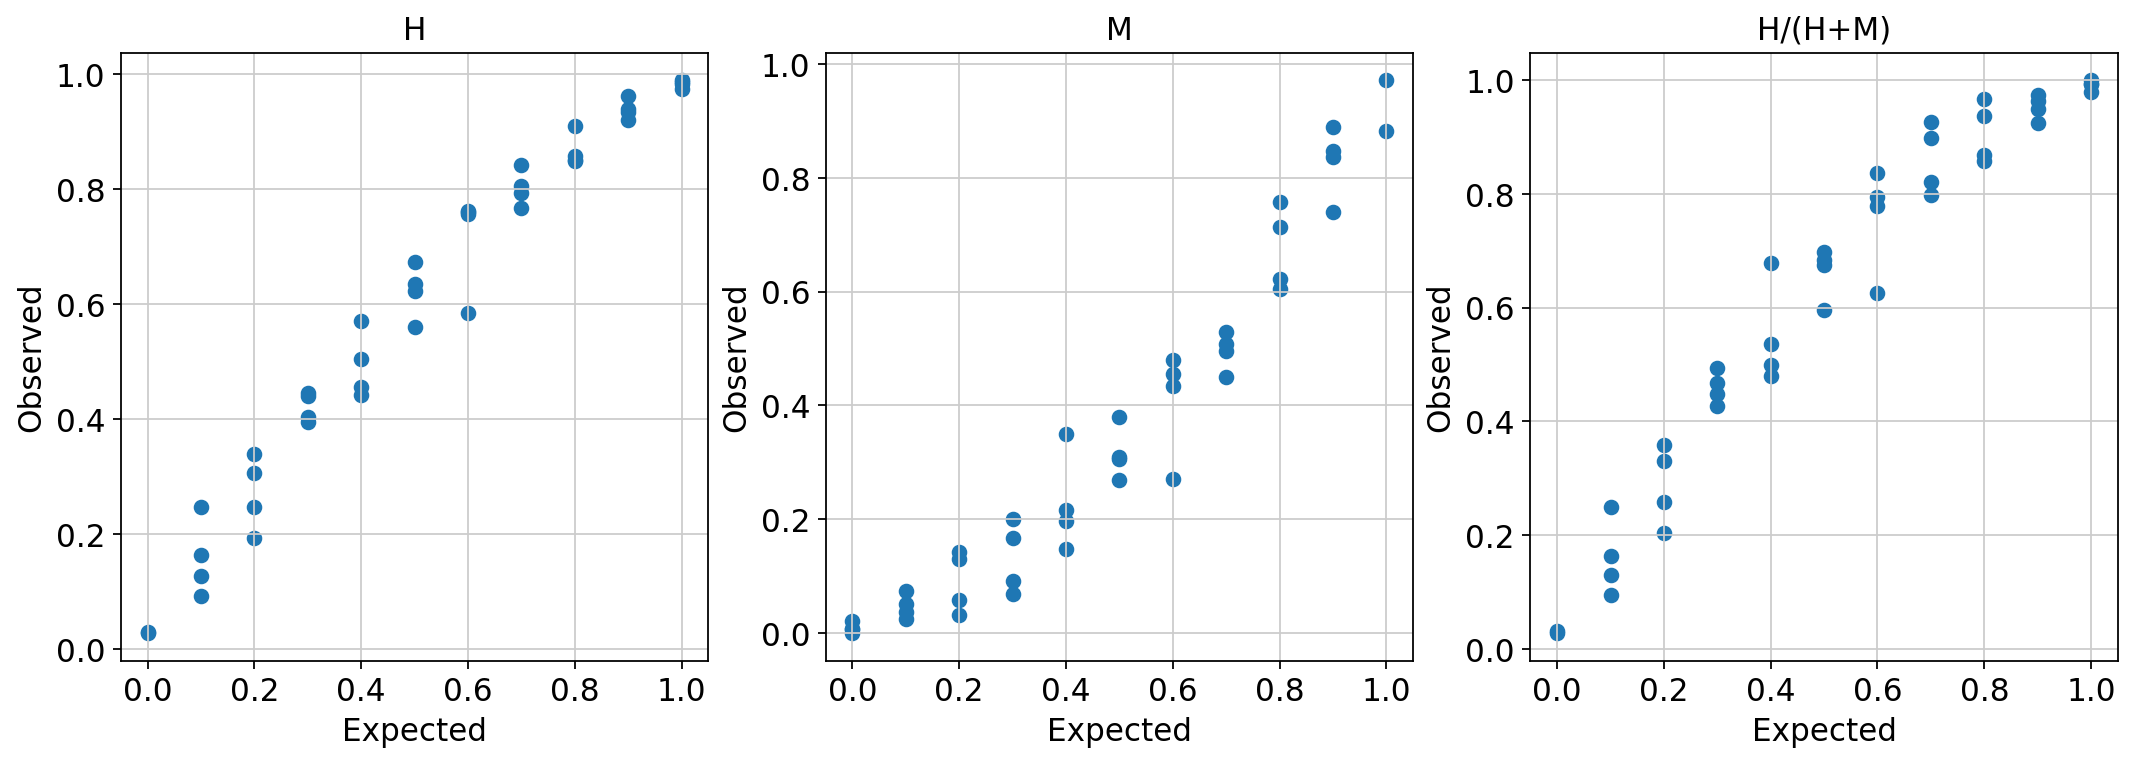

In [62]:
fig, ax = plt.subplots(1,3,figsize=(16,5))
for ax, species in zip(ax,['H', 'M', 'H/(H+M)']):
    ax.scatter(col_props[species].values, df[species].values);
    ax.set_title(species)
    ax.set_xlabel('Expected')
    ax.set_ylabel('Observed')